In [ ]:
!pip install ccxt


[ticks] bitstamp: 50,000 | 2025-11-12 01:24:06+00:00 → 2025-11-12 18:16:23+00:00

Источник: bitstamp | тиков: 50,000 | диапазон: 2025-11-12 01:24:06+00:00 → 2025-11-12 18:16:23+00:00
TRIALS=10 | окно L∈[10,000, 50,000] | fee=0.0004

Итоги по окнам (первые 5):
 trial  ticks  classic_no_fee  double_no_fee  hybrid_no_fee  classic_fee  hybrid_fee
     1  37303           34.56          31.54          33.98        34.45       33.87
     2  10666           10.18           7.96           8.51        10.09        8.42
     3  34144           33.07          28.04          29.50        32.96       29.40
     4  22691           16.65          17.83          18.47        16.55       18.38
     5  47093           40.01          40.26          45.69        39.89       45.57

Сводка (по всем окнам):
                mean_%  median_%  std_%
classic_no_fee   26.27     26.30  10.80
double_no_fee    25.02     23.69  10.83
hybrid_no_fee    27.44     24.56  12.39
classic_fee      26.17     26.20  10.79
hybri

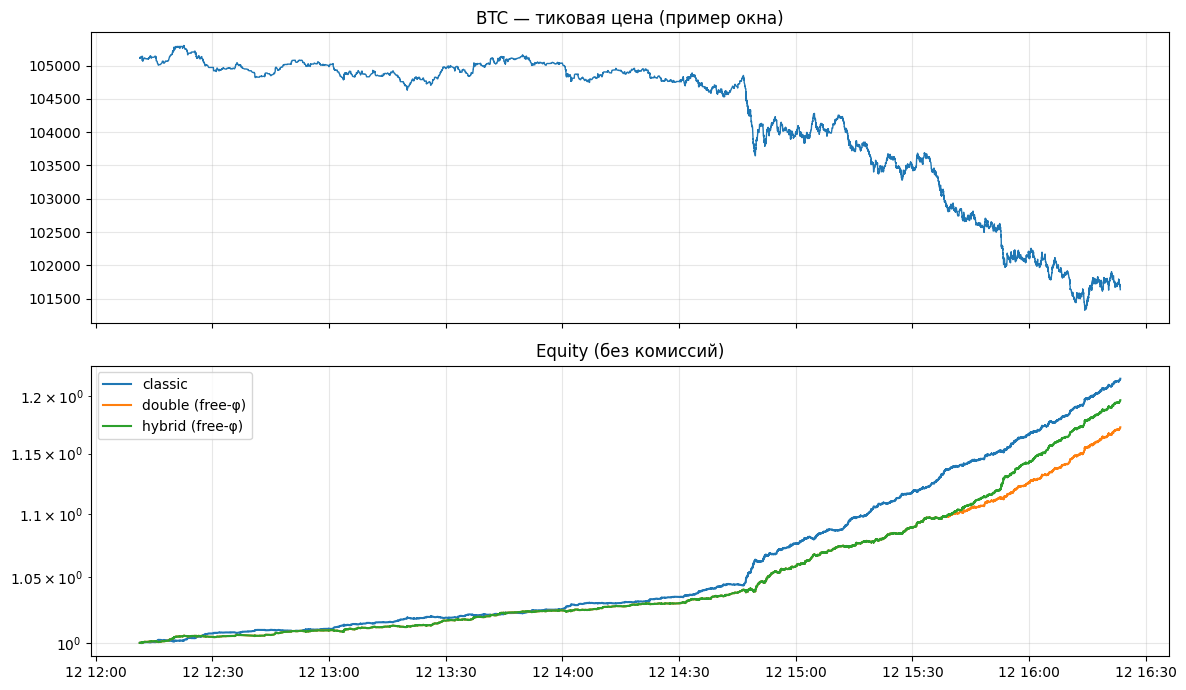

In [19]:
# @title BTC — WARP (ticks, φ/ψ) — чистый скрипт с рандомными окнами
# -*- coding: utf-8 -*-
import os, time, json, math, random, requests, traceback
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from datetime import datetime, timezone

# ==========================
# БАЗИС φ/ψ (минимально)
# ==========================
PHI = (1 + 5**0.5) / 2.0        # φ
PSI = 1.0 / PHI                 # ψ
UP_MUL   = 1.0 + PSI**2         # шаг "в пользу"
DOWN_MUL = 1.0 - PSI            # шаг "против"

assert 0 < PSI < 1 < PHI
assert abs((UP_MUL - 1.0) - PSI**2) < 1e-14
assert abs((1.0 - DOWN_MUL) - PSI)  < 1e-14

def phi_boundaries(n:int):
    """Золотые точки по длине окна."""
    B = int(n * PSI)
    A = int(n * (PSI + (1 - PSI) * PSI))
    return B, A

# ==========================
# ЗАГРУЗКА ТИКОВ (Bitstamp → Kraken → Coinbase)
# ==========================
OUT_DIR = "/content/phi_warp_out"; os.makedirs(OUT_DIR, exist_ok=True)
UA = {"User-Agent": "phi-warp/minimal"}
REQ_TIMEOUT_S = 12
LIMIT = 50_000   # сколько тиков сохраняем у выбранного источника

def to_dt_utc(x):
    try:
        v = float(x); is_ms = v > 1e11
        return pd.to_datetime(int(v), unit=("ms" if is_ms else "s"), utc=True, errors="coerce")
    except Exception:
        return pd.to_datetime(x, utc=True, errors="coerce")

def tidy(df, price_col="price", time_col="time"):
    if df is None or len(df)==0: return None
    if not {price_col, time_col}.issubset(df.columns): return None
    out = df[[time_col, price_col]].copy()
    out[price_col] = pd.to_numeric(out[price_col], errors="coerce")
    out[time_col]  = out[time_col].map(to_dt_utc)
    out = out.dropna().sort_values(time_col)
    out = out[out[price_col] > 0]
    if len(out)==0: return None
    out = out.tail(LIMIT).reset_index(drop=True)
    out.columns = ["time", "price"]
    return out

def load_bitstamp():
    url = "https://www.bitstamp.net/api/v2/transactions/btcusd/"
    r = requests.get(url, params={"time":"day"}, headers=UA, timeout=REQ_TIMEOUT_S); r.raise_for_status()
    data = r.json()
    df = pd.DataFrame(data)[["date","price"]].rename(columns={"date":"time"})
    df["time"] = pd.to_numeric(df["time"], errors="coerce")
    return tidy(df, "price", "time")

def load_kraken():
    url = "https://api.kraken.com/0/public/Trades"
    r = requests.get(url, params={"pair":"XBTUSD"}, headers=UA, timeout=REQ_TIMEOUT_S); r.raise_for_status()
    j = r.json()
    if j.get("error"): return None
    result = j.get("result", {})
    key = [k for k in result.keys() if k!="last"]
    if not key: return None
    trades = result[key[0]]  # [price, volume, time, ...]
    rows = [{"time": float(t[2]), "price": float(t[0])} for t in trades]
    return tidy(pd.DataFrame(rows), "price", "time")

def load_coinbase():
    url = "https://api.exchange.coinbase.com/products/BTC-USD/trades"
    r = requests.get(url, headers={"Accept":"application/json", **UA}, timeout=REQ_TIMEOUT_S); r.raise_for_status()
    data = r.json()
    df = pd.DataFrame(data)
    return tidy(df, "price", "time")

def load_ticks():
    for name, fn in [("bitstamp",load_bitstamp), ("kraken",load_kraken), ("coinbase",load_coinbase)]:
        try:
            df = fn()
            if df is not None and len(df) > 0:
                sel_path = os.path.join(OUT_DIR, f"{name}_ticks.csv")
                df.to_csv(sel_path, index=False)
                # Короткая сводка
                t0, t1 = df["time"].iloc[0], df["time"].iloc[-1]
                print(f"[ticks] {name}: {len(df):,} | {t0} → {t1}")
                return df, name
        except Exception:
            pass
    raise RuntimeError("Нет данных у Bitstamp/Kraken/Coinbase.")

# ==========================
# СТРАТЕГИИ (3 штуки)
# ==========================
def classic_flip(prices, fee_per_flip=0.0):
    """Жёсткий φ-flip: одна позиция; объём в [ψ, φ]; комиссия только на дискретном flip."""
    n = len(prices); B,A = phi_boundaries(n)
    sgn = (lambda i: -1 if i < B else (+1 if i < A else -1))
    eq=[1.0]; pos=sgn(0); vol=1.0; flips=0
    for i in range(1,n):
        r = (prices[i]-prices[i-1])/prices[i-1]; s = sgn(i)
        if s != pos:
            if fee_per_flip>0: eq[-1] *= (1.0 - fee_per_flip)
            pos = s; vol = 1.0; flips += 1
        else:
            fav = (pos * r > 0)
            vol *= (UP_MUL if fav else DOWN_MUL)
            if vol < PSI: vol = PSI
            if vol > PHI: vol = PHI
        eq.append(eq[-1] * (1.0 + pos * vol * r))
    return {"eq":np.array(eq), "flips":flips, "B":B, "A":A}

def double_free_phi(prices):
    """Два потока (long/short) со свободной «энергией» + φ-клип суммы массы."""
    n=len(prices); eq=[1.0]; vL=1.0; vS=1.0
    for i in range(1,n):
        r = (prices[i]-prices[i-1])/prices[i-1]
        vL *= (UP_MUL if r>0 else DOWN_MUL)
        vS *= (UP_MUL if r<0 else DOWN_MUL)
        s = vL + vS
        if s > PHI:   # клип вниз до φ
            k = PHI/s; vL *= k; vS *= k
        elif s < PSI: # клип вверх до ψ
            k = PSI/s; vL *= k; vS *= k
        net = vL - vS                    # ∈ [−φ, +φ]
        eq.append(eq[-1] * (1.0 + net * r))
    return {"eq":np.array(eq)}

def hybrid_phi(prices, fee_per_rebal=0.0):
    """Двойная free-φ + жёсткий φ-ребаланс в B/A (50/50); комиссия только на ребаланс."""
    n=len(prices); B,A = phi_boundaries(n)
    eq=[1.0]; vL=1.0; vS=1.0; rbs=0
    for i in range(1,n):
        r = (prices[i]-prices[i-1])/prices[i-1]
        vL *= (UP_MUL if r>0 else DOWN_MUL)
        vS *= (UP_MUL if r<0 else DOWN_MUL)
        if i==B or i==A:
            if fee_per_rebal>0: eq[-1] *= (1.0 - fee_per_rebal)
            vL = vS = 0.5; rbs += 1       # симм. сброс → сумма = 1 ∈ [ψ, φ]
        s = vL + vS
        if s > PHI:
            k = PHI/s; vL *= k; vS *= k
        elif s < PSI:
            k = PSI/s; vL *= k; vS *= k
        net = vL - vS
        eq.append(eq[-1] * (1.0 + net * r))
    return {"eq":np.array(eq), "rebalances":rbs, "B":B, "A":A}

def ret_pct(eq): return (float(eq[-1]) - 1.0) * 100.0

# ==========================
# ОДИН ПРОГОН НА ОКНЕ
# ==========================
def run_on_window(prices, fee=0.0):
    res = {}
    # без комиссий
    c0 = classic_flip(prices, fee_per_flip=0.0)
    d0 = double_free_phi(prices)
    h0 = hybrid_phi(prices, fee_per_rebal=0.0)
    # с комиссиями (только дискретные действия)
    c1 = classic_flip(prices, fee_per_flip=fee)
    h1 = hybrid_phi(prices, fee_per_rebal=fee)
    res["classic_no_fee"] = ret_pct(c0["eq"])
    res["double_no_fee"]  = ret_pct(d0["eq"])
    res["hybrid_no_fee"]  = ret_pct(h0["eq"])
    res["classic_fee"]    = ret_pct(c1["eq"])
    res["hybrid_fee"]     = ret_pct(h1["eq"])
    res["flips"]          = c0["flips"]
    res["rebalances"]     = h0["rebalances"]
    return res

# ==========================
# МНОГОКРАТНЫЕ СЛУЧАЙНЫЕ ОКНА
# ==========================
SEED        = 12345        # фиксируем для воспроизводимости
TRIALS      = 10           # сколько окон
MIN_LEN     = 10_000       # минимум тиков в окне
MAX_LEN     = None         # None → до всей длины (ограничим автоматически)
FEE_OBS     = 0.0004       # комиссия наблюдателя на flip/rebalance

df, source = load_ticks()
prices_all = df["price"].to_numpy(dtype=float)
times_all  = df["time"].to_numpy()
N = len(prices_all)
if MAX_LEN is None: MAX_LEN = min(N, 50_000)

rng = random.Random(SEED)
rows = []
for t in range(TRIALS):
    L = rng.randint(MIN_LEN, MAX_LEN)
    i0 = rng.randint(0, N - L)
    win = prices_all[i0:i0+L]
    out = run_on_window(win, fee=FEE_OBS)
    rows.append({
        "trial": t+1,
        "start_time": str(times_all[i0]),
        "end_time": str(times_all[i0+L-1]),
        "ticks": L,
        **out
    })

res_df = pd.DataFrame(rows)

# Сводка по стратегиям
def summ(col):
    s = res_df[col]
    return pd.Series({
        "mean_%": s.mean(),
        "median_%": s.median(),
        "std_%": s.std()
    })

summary = pd.concat([
    summ("classic_no_fee").rename("classic_no_fee"),
    summ("double_no_fee").rename("double_no_fee"),
    summ("hybrid_no_fee").rename("hybrid_no_fee"),
    summ("classic_fee").rename("classic_fee"),
    summ("hybrid_fee").rename("hybrid_fee"),
], axis=1).T

# Доп. метрики превосходства
wins = pd.DataFrame({
    "double>classic (no_fee)": (res_df["double_no_fee"] > res_df["classic_no_fee"]).mean(),
    "hybrid>classic (no_fee)": (res_df["hybrid_no_fee"] > res_df["classic_no_fee"]).mean(),
    "hybrid>classic (with_fee)": (res_df["hybrid_fee"] > res_df["classic_fee"]).mean(),
}, index=["share"])

# Тихий компактный вывод
pd.set_option("display.float_format", lambda v: f"{v:,.2f}")
print(f"\nИсточник: {source} | тиков: {N:,} | диапазон: {times_all[0]} → {times_all[-1]}")
print(f"TRIALS={TRIALS} | окно L∈[{MIN_LEN:,}, {MAX_LEN:,}] | fee={FEE_OBS}")
print("\nИтоги по окнам (первые 5):")
print(res_df.head(5)[["trial","ticks","classic_no_fee","double_no_fee","hybrid_no_fee","classic_fee","hybrid_fee"]].to_string(index=False))
print("\nСводка (по всем окнам):")
print(summary.to_string())
print("\nДоли побед (по всем окнам):")
print(wins.to_string())

# Сохранения (без лишних принтов)
res_path = os.path.join(OUT_DIR, "warp_windows_results.csv")
sum_path = os.path.join(OUT_DIR, "warp_windows_summary.csv")
res_df.to_csv(res_path, index=False)
summary.to_csv(sum_path)

# (опционально) график для последнего окна
SHOW_SAMPLE_PLOT = True
if SHOW_SAMPLE_PLOT:
    L = res_df.iloc[-1]["ticks"]; i0 = next(i for i in range(N-L) if str(times_all[i]) == res_df.iloc[-1]["start_time"])
    i1 = i0 + L
    win_prices = prices_all[i0:i1]
    c0 = classic_flip(win_prices, fee_per_flip=0.0)
    d0 = double_free_phi(win_prices)
    h0 = hybrid_phi(win_prices, fee_per_rebal=0.0)

    fig, ax = plt.subplots(2, 1, figsize=(12,7), sharex=True)
    ax[0].plot(times_all[i0:i1], win_prices, linewidth=1)
    ax[0].set_title("BTC — тиковая цена (пример окна)"); ax[0].grid(True, alpha=0.3)
    ax[1].plot(times_all[i0:i1], c0["eq"], label="classic")
    ax[1].plot(times_all[i0:i1], d0["eq"], label="double (free-φ)")
    ax[1].plot(times_all[i0:i1], h0["eq"], label="hybrid (free-φ)")
    ax[1].set_yscale("log"); ax[1].set_title("Equity (без комиссий)"); ax[1].grid(True, alpha=0.3); ax[1].legend()
    plt.tight_layout()
    fig_path = os.path.join(OUT_DIR, "sample_window_plot.png")
    plt.savefig(fig_path, dpi=150); plt.show()

# Короткий манифест
meta = {
    "utc": datetime.now(timezone.utc).replace(microsecond=0).isoformat(),
    "phi": PHI, "psi": PSI, "trials": TRIALS,
    "min_len": MIN_LEN, "max_len": MAX_LEN, "fee": FEE_OBS,
    "source": source, "ticks_total": int(N),
    "artifacts": {"results_csv": res_path, "summary_csv": sum_path}
}
with open(os.path.join(OUT_DIR, "warp_manifest.json"), "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)